In [1]:
import pandas as pd
import re
import pprint

# ✅ เปลี่ยนชื่อไฟล์ CSV ตรงนี้

df = pd.read_csv("combined_all_part3.csv")

def norm(val):
    if not isinstance(val, str):
        return ''
    val = val.strip().lower()
    if val == 'not found':
        return ''
    if val == 'timeout':
        return 'timeout'
    return val

results = {}

def apply_analysis(column, func):
    df[column + '_status'] = df[column].apply(func)
    results[column] = df[column + '_status'].value_counts().to_dict()

# 1. Content-Security-Policy
def analyze_csp(v):
    v = norm(v)
    if v == '': return 'missing'
    if v == 'timeout': return 'timeout'
    issues = []
    if 'unsafe-inline' in v or 'unsafe-eval' in v or '*' in v:
        issues.append('insecure')
    if 'default-src' not in v:
        issues.append('no-default-src')
    return ','.join(issues) if issues else 'valid'
apply_analysis('Content-Security-Policy', analyze_csp)

# 1.1 CSP Report-Only
if 'Content-Security-Policy-Report-Only' in df.columns:
    def analyze_cspro(v):
        v = norm(v)
        if v == '': return 'missing'
        if v == 'timeout': return 'timeout'
        return 'no-report-uri' if 'report-uri' not in v else 'valid'
    apply_analysis('Content-Security-Policy-Report-Only', analyze_cspro)

# 2. X-Frame-Options
apply_analysis('X-Frame-Options', lambda v: 'valid' if (v := norm(v)) in ['deny', 'sameorigin'] else ('missing' if v == '' else v if v == 'timeout' else 'invalid'))

# 3. Referrer-Policy
def analyze_ref(v):
    v = norm(v)
    if v == '': return 'missing'
    if v == 'timeout': return 'timeout'
    valid = ['no-referrer', 'no-referrer-when-downgrade', 'origin', 'origin-when-cross-origin', 'same-origin', 'strict-origin', 'strict-origin-when-cross-origin', 'unsafe-url']
    return 'valid' if all(i.strip() in valid for i in v.split(',')) else 'invalid'
apply_analysis('Referrer-Policy', analyze_ref)

# 4. Permissions-Policy
apply_analysis('Permissions-Policy', lambda v: 'invalid' if re.search(r"[a-z\-]+\s*=\s*\*", (v := norm(v))) else ('missing' if v == '' else v if v == 'timeout' else 'valid'))

# 5. X-XSS-Protection
def analyze_xss(v):
    v = norm(v)
    if v == '': return 'missing'
    if v == 'timeout': return 'timeout'
    if v == '0': return 'disabled'
    if 'mode=enable' in v: return 'invalid'
    return 'valid'
apply_analysis('X-XSS-Protection', analyze_xss)

# 6. Public-Key-Pins
def analyze_hpkp(v):
    v = norm(v)
    if v == '': return 'missing'
    if v == 'timeout': return 'timeout'
    return 'valid' if 'pin-sha256' in v and 'max-age' in v else 'malformed'
apply_analysis('Public-Key-Pins', analyze_hpkp)

# 7. Pragma (with Cache-Control)
def analyze_pragma(row):
    v = norm(row.get('Pragma'))
    cache = norm(row.get('Cache-Control'))
    if v == 'timeout' or cache == 'timeout': return 'timeout'
    if 'no-cache' in v:
        if cache == '' or 'no-store' not in cache:
            return 'pragma-only-no-cache'
        return 'has-cache-control'
    return 'other'
df['Pragma_status'] = df.apply(analyze_pragma, axis=1)
results['Pragma'] = df['Pragma_status'].value_counts().to_dict()

# 8. X-Content-Type-Options
apply_analysis('X-Content-Type-Options', lambda v: 'valid' if (v := norm(v)) == 'nosniff' else ('missing' if v == '' else v if v == 'timeout' else 'invalid'))

# 9. Cross-Origin-Embedder-Policy
apply_analysis('Cross-Origin-Embedder-Policy', lambda v: 'valid' if (v := norm(v)) in ['require-corp', 'credentialless'] else ('missing' if v == '' else v if v == 'timeout' else 'invalid'))

# 10. Cross-Origin-Opener-Policy
def analyze_coop(v):
    v = norm(v)
    if v == '': return 'missing'
    if v == 'timeout': return 'timeout'
    return 'unsafe' if v == 'unsafe-none' else ('valid' if v in ['same-origin', 'same-origin-allow-popups'] else 'invalid')
apply_analysis('Cross-Origin-Opener-Policy', analyze_coop)

# 11. Cross-Origin-Resource-Policy
apply_analysis('Cross-Origin-Resource-Policy', lambda v: 'valid' if (v := norm(v)) in ['same-origin', 'same-site', 'cross-origin'] else ('missing' if v == '' else v if v == 'timeout' else 'invalid'))

# 12. Clear-Site-Data
apply_analysis('Clear-Site-Data', lambda v: 'valid' if ('"cache"' in (v := norm(v)) and '"cookies"' in v) else ('missing' if v == '' else v if v == 'timeout' else 'invalid'))

# 13. Cache-Control
def analyze_cc(v):
    v = norm(v)
    if v == '': return 'missing'
    if v == 'timeout': return 'timeout'
    directives = [d.strip() for d in v.split(',')]
    if 'public' in directives and 'no-store' in directives:
        return 'conflict: public + no-store'
    if len(re.findall(r"max-age=\d+", v)) > 1:
        return 'conflict: multiple max-age'
    if 'no-cache' in directives and 'no-store' not in directives and 'must-revalidate' not in directives:
        return 'incomplete: no-cache only'
    return 'valid'
apply_analysis('Cache-Control', analyze_cc)

# 14. Expect-CT
def analyze_ect(v):
    v = norm(v)
    if v == '': return 'missing'
    if v == 'timeout': return 'timeout'
    if 'enforce' in v and 'max-age' not in v:
        return 'enforce-no-max-age'
    if 'report-only' in v and 'report-uri' not in v:
        return 'report-only-no-uri'
    return 'valid'
apply_analysis('Expect-CT', analyze_ect)

# 15. Feature-Policy
apply_analysis('Feature-Policy', lambda v: 'used' if (v := norm(v)) not in ['', 'timeout'] else v if v == 'timeout' else 'missing')

# 16. X-Permitted-Cross-Domain-Policies
apply_analysis('X-Permitted-Cross-Domain-Policies', lambda v: 'valid' if (v := norm(v)) in ['none', 'master-only', 'by-content-type', 'all'] else ('missing' if v == '' else v if v == 'timeout' else 'invalid'))

# ✅ แสดงผลสรุปทั้งหมด
pprint.pprint(results)
with open("results_summary.txt", "w", encoding="utf-8") as f:
    for header, summary in results.items():
        f.write(f"== {header} ==\n")
        for key, count in summary.items():
            f.write(f"{key}: {count}\n")
        f.write("\n")

{'Cache-Control': {'conflict: multiple max-age': 2904,
                   'conflict: public + no-store': 1813,
                   'incomplete: no-cache only': 29746,
                   'missing': 313246,
                   'timeout': 229002,
                   'valid': 423289},
 'Clear-Site-Data': {'invalid': 130,
                     'missing': 770867,
                     'timeout': 229002,
                     'valid': 1},
 'Content-Security-Policy': {'insecure': 29904,
                             'insecure,no-default-src': 13038,
                             'missing': 656750,
                             'no-default-src': 70771,
                             'timeout': 229002,
                             'valid': 535},
 'Cross-Origin-Embedder-Policy': {'invalid': 3280,
                                  'missing': 714178,
                                  'timeout': 229002,
                                  'valid': 53540},
 'Cross-Origin-Opener-Policy': {'invalid': 722,
         

In [2]:
summary_df = pd.DataFrame.from_dict(results, orient='index').fillna(0).astype(int)
summary_df.to_csv("summary_results.csv")
summary_df

,missing,timeout,no-default-src,insecure,"insecure,no-default-src",valid,invalid,disabled,malformed,other,has-cache-control,pragma-only-no-cache,unsafe,incomplete: no-cache only,conflict: multiple max-age,conflict: public + no-store,enforce-no-max-age,used
Content-Security-Policy,656750,229002,70771,29904,13038,535,0,0,0,0,0,0,0,0,0,0,0,0
X-Frame-Options,507007,229002,0,0,0,248692,15299,0,0,0,0,0,0,0,0,0,0,0
Referrer-Policy,606894,229002,0,0,0,163886,218,0,0,0,0,0,0,0,0,0,0,0
Permissions-Policy,685058,229002,0,0,0,81532,4408,0,0,0,0,0,0,0,0,0,0,0
X-XSS-Protection,596690,229002,0,0,0,166361,0,7947,0,0,0,0,0,0,0,0,0,0
Public-Key-Pins,770725,229002,0,0,0,267,0,0,6,0,0,0,0,0,0,0,0,0
X-Content-Type-Options,496021,229002,0,0,0,267110,7867,0,0,0,0,0,0,0,0,0,0,0
Cross-Origin-Embedder-Policy,714178,229002,0,0,0,53540,3280,0,0,0,0,0,0,0,0,0,0,0
Cross-Origin-Opener-Policy,708593,229002,0,0,0,59720,722,0,0,0,0,0,1963,0,0,0,0,0
Cross-Origin-Resource-Policy,712550,229002,0,0,0,58033,415,0,0,0,0,0,0,0,0,0,0,0


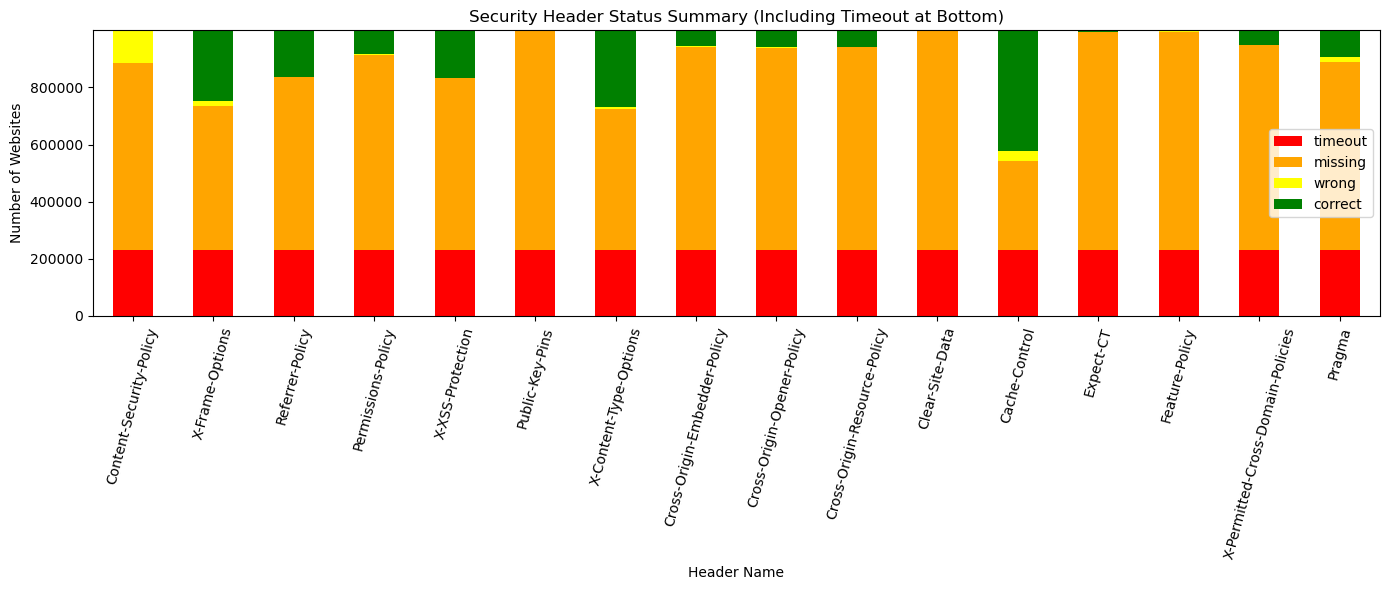

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ แปลง results เป็น DataFrame และเติมช่องว่างเป็น 0
summary_df = pd.DataFrame.from_dict(results, orient='index').fillna(0)

# ✅ กำหนดกลุ่มค่าที่เป็น “ผิด” (ตามที่วิเคราะห์จากข้อมูลจริง)
error_labels = [
    'invalid',
    'insecure', 'no-default-src', 'insecure,no-default-src',
    'malformed',
    'pragma-only-no-cache',
    'conflict: public + no-store', 'conflict: multiple max-age',
    'incomplete: no-cache only',
    'enforce-no-max-age',
    'used',
    'unsafe'
]

summary_df = pd.DataFrame.from_dict(summary_dict, orient='index').fillna(0)
summary_df['correct'] = summary_df.get('valid', 0)
existing_errors = [col for col in error_labels if col in summary_df.columns]
summary_df['wrong'] = summary_df[existing_errors].sum(axis=1)
summary_df['missing'] = summary_df.get('missing', 0)

# 🔧 ปรับ Pragma เป็นพิเศษ
summary_df.loc["Pragma", "correct"] = summary_df.loc["Pragma"].get("has-cache-control", 0)
summary_df.loc["Pragma", "wrong"] = summary_df.loc["Pragma"].get("pragma-only-no-cache", 0)
summary_df.loc["Pragma", "missing"] = summary_df.loc["Pragma"].get("other", 0)

# 🎨 สร้างกราฟ stacked bar ไม่รวม timeout
plot_df_clean = summary_df[['correct', 'wrong', 'missing']]
plot_df_clean.plot(kind='bar', stacked=True, figsize=(14, 6), color=["green", "yellow", "orange"])
plt.title("Security Header Status Summary (Excluding Timeout)")
plt.ylabel("Number of Websites")
plt.xlabel("Header Name")
plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig("header_graph_without_timeout.png")  # บันทึกไฟล์ PNG
plt.show()

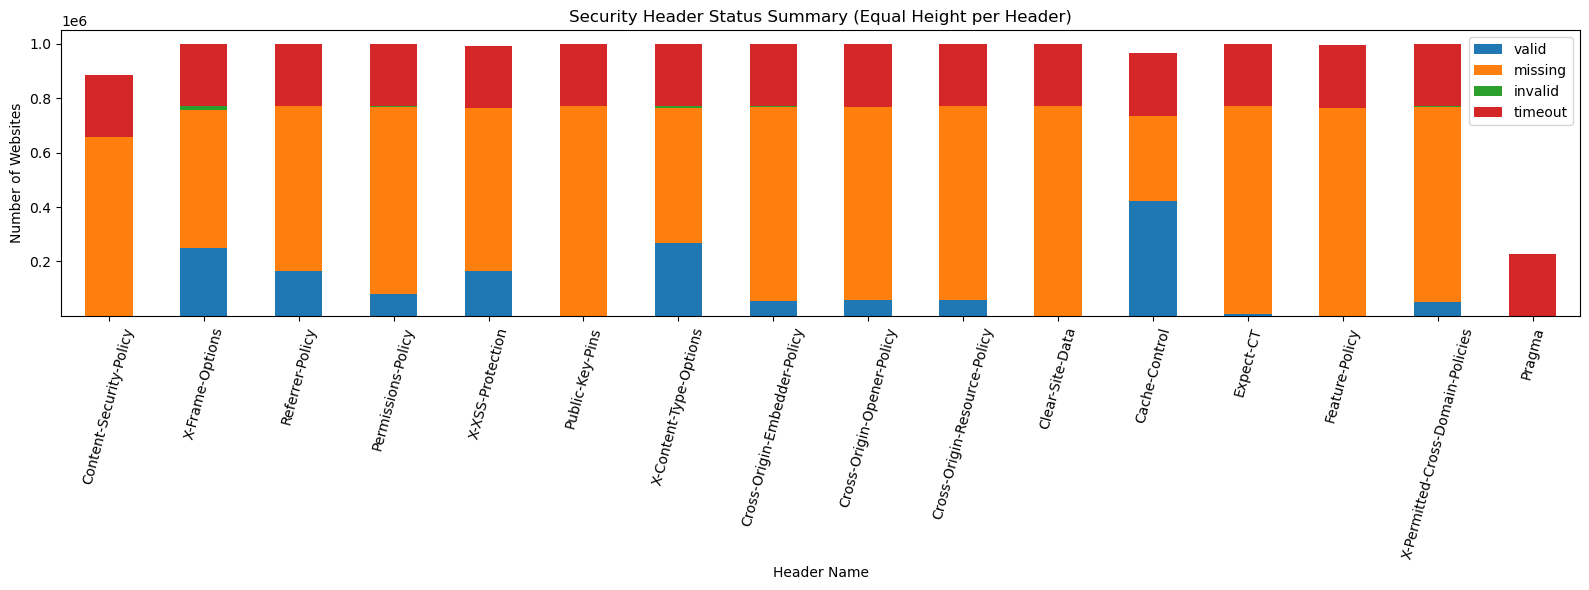

In [40]:
import matplotlib.pyplot as plt

# ✅ แปลง results เป็น DataFrame แล้วเติมค่าว่างให้เป็น 0
summary_df = pd.DataFrame.from_dict(results, orient='index').fillna(0).astype(int)

# ✅ เลือกเฉพาะคอลัมน์หลักที่ต้องการให้เปรียบเทียบความสูง
columns = ['valid', 'missing', 'invalid', 'timeout']
for col in columns:
    if col not in summary_df.columns:
        summary_df[col] = 0  # บาง header ไม่มี 'invalid' หรือ 'valid'

# ✅ เรียงคอลัมน์เพื่อให้สีเหมือนเดิม
summary_df = summary_df[columns]

# ✅ วาดกราฟ bar แบบ stacked เท่ากัน
summary_df.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    title="Security Header Status Summary (Equal Height per Header)"
)
plt.ylabel("Number of Websites")
plt.xlabel("Header Name")
plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig("header_summary_equal_height.png")
plt.show()


In [26]:
import pandas as pd

# โหลดข้อมูล (กรณีที่ยังไม่โหลด)
df = pd.read_csv("combined_all_part3.csv")

# แทนค่าว่าง string '' ให้กลายเป็น NaN ด้วย
df = df.replace('', pd.NA)

# ✅ นับจำนวนแถวที่ “มีข้อมูล” (non-null)
non_empty_counts = df.notna().sum()

# ✅ นับจำนวนแถวที่ “ว่าง” (null หรือ NaN)
empty_counts = df.isna().sum()

# ✅ รวมเป็นตารางเดียว
column_check = pd.DataFrame({
    'Total Rows': len(df),
    'Non-Empty Rows': non_empty_counts,
    'Empty Rows': empty_counts
})

# แสดงผล
import pprint
pprint.pprint(column_check)


                                   Total Rows  Non-Empty Rows  Empty Rows
Domain                                1000000         1000000           0
Strict-Transport-Security             1000000         1000000           0
X-Frame-Options                       1000000         1000000           0
X-Content-Type-Options                1000000         1000000           0
Content-Security-Policy               1000000         1000000           0
X-Permitted-Cross-Domain-Policies     1000000         1000000           0
Referrer-Policy                       1000000         1000000           0
Clear-Site-Data                       1000000         1000000           0
Cross-Origin-Embedder-Policy          1000000         1000000           0
Cross-Origin-Opener-Policy            1000000         1000000           0
Cross-Origin-Resource-Policy          1000000         1000000           0
Cache-Control                         1000000         1000000           0
Permissions-Policy                    